# Notebook to show the tools that can help when comparing time series models

In [1]:
import numpy as np
import pastas as ps
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, concat
from itertools import combinations
from pastas.plots import _table_formatter_params
ps.set_log_level('ERROR')

%load_ext autoreload
%autoreload 2


## Load Time Series

In [2]:
rain = read_csv("../data/rain_nb1.csv", index_col=0,
                parse_dates=True).squeeze()
evap = read_csv("../data/evap_nb1.csv", index_col=0,
                parse_dates=True).squeeze()
obs1 = read_csv("../data/head_nb1.csv", index_col=0,
                parse_dates=True).squeeze()
obs2 = read_csv("../data/nb18_head.csv", index_col=0,
                parse_dates=True).squeeze()


# Create three models

* Model1 has observations series 1 with has linear recharge model
* Model2 has observation series 1 with precipitation and evaporation as seperate stresses
* Model3 has observation series 2 with linear recharge model of model 1

In [3]:
ml1a = ps.Model(obs1, name="1a_exp")
sm1a = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="recharge")
ml1a.add_stressmodel(sm1a)
ml1a.solve(report=False, noise=True)

ml1b = ps.Model(obs1, name="1b_gamma")
sm1b = ps.RechargeModel(rain, evap, rfunc=ps.Gamma, name="recharge")
ml1b.add_stressmodel(sm1b)
ml1b.solve(report=False, noise=True)

ml2 = ps.Model(obs1, name="Model2")
sm2_1 = ps.StressModel(rain, rfunc=ps.Gamma, name="Prec", settings="prec")
sm2_2 = ps.StressModel(evap, rfunc=ps.Gamma, name="Evap",
                       settings="evap", up=False)
[ml2.add_stressmodel(x) for x in (sm2_1, sm2_2)]
# sm2 = ps.RechargeModel(rain.multiply(1e3), evap.multiply(1e3), rfunc=ps.Exponential, recharge=ps.rch.FlexModel())
# ml2.add_stressmodel(sm2)
ml2.solve(report=False, noise=True)

ml3 = ps.Model(obs2, name="Model3")
ml3.add_stressmodel(sm1a)
ml3.solve(report=False, noise=True)


# Model Comparison Class

In [4]:
class ModelComparison:
    def __init__(self, models=None):
        """
        Initialize model compare class.
        """
        self.models = models
        self.figure = None
        self.axes = None
        self.mosaic = None
        self.cmap = None

    def initialize_figure(self, mosaic=None, figsize=(10, 8), cmap="tab10"):
        """
        Initialize a custom figure based on a mosaic.

        Parameters
        ----------
        mosaic : list, optional
            Subplot mosaic, by default None which uses the default mosaic.
        figsize : tuple, optional
            Figure size, by default (10, 8)
        cmap : str, optional
            Matplotlib colormap, by default tab10
        """
        if mosaic is None:
            u_sm = self.get_unique_stressmodels(models=self.models)
            mosaic = self.get_default_mosaic(len(u_sm))

        self.mosaic = mosaic
        figure, axes = plt.subplot_mosaic(self.mosaic, figsize=figsize)
        self.figure = figure
        self.axes = axes
        self.cmap = plt.get_cmap(cmap)

    def get_unique_stressmodels(self, models=None, combine=None):
        """
        Get all unique stressmodel names.
        """
        if models is None:
            models = self.models

        sm_unique = []
        for ml in models:
            [
                sm_unique.append(x)
                for x in ml.get_stressmodel_names()
                if x not in sm_unique
            ]

        return sm_unique

    def get_default_mosaic(self, n_stressmodels=0):
        """
        Get default mosaic for matplotlib.subplot_mosaic().
        """
        mosaic = [
            ["sim", "sim", "met"],
            ["sim", "sim", "tab"],
            ["res", "res", "tab"],
        ]
        for i in range(n_stressmodels):
            mosaic.append([f"con{i}", f"con{i}", f"rf{i}"])

        return mosaic

    def get_tmin_tmax(self, models=None):
        """
        Get tmin and tmax of all models.
        """
        if models is None:
            models = self.models

        tmintmax = DataFrame(columns=["tmin", "tmax"], dtype="datetime64[ns]")
        for ml in models:
            tmintmax.loc[ml.name, ["tmin", "tmax"]] = [
                ml.get_tmin(),
                ml.get_tmax(),
            ]

        return tmintmax

    def get_metrics(
        self, models=None, metric_selection=None
    ):
        """
        Get metrics of all models in a DataFrame.
        """
        if models is None:
            models = self.models

        metrics = concat([ml.stats.summary(stats=metric_selection)
                         for ml in models], axis=1, sort=False)
        metrics.columns = [ml.name for ml in models]
        metrics.index.name = None

        return metrics

    def get_parameters(
        self, models=None, param_col="optimal", param_selection=None
    ):
        """
        Get parameter values of all models in a DataFrame.
        """
        if models is None:
            models = self.models

        params = concat([ml.parameters[param_col]
                        for ml in models], axis=1, sort=False)
        params.columns = [x.name for x in models]

        if param_selection:
            sel = np.array([])
            for sub in param_selection:
                sel = np.append(
                    sel, [idx for idx in params.index if sub in idx]
                )
            return params.loc[sel].sort_index()
        else:
            return params

    def get_diagnostics(
        self, models=None
    ):
        """
        Get p-values of statistical tests in a DataFrame.
        """
        if models is None:
            models = self.models

        diags = DataFrame(index=[f"{x.name}_pvalue" for x in models])
        for i, ml in enumerate(models):
            mldiag = ml.stats.diagnostics()
            diags.loc[f"{ml.name}_pvalue", mldiag.index] = mldiag[
                "P-value"
            ].values

        return diags.transpose()

    def plot_oseries(
        self, axn="sim"
    ):
        """
        Plot all oseries, unless all oseries are the same.
        """
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        oseries = [ml.oseries.series for ml in self.models]
        equals = np.array([])
        for pair in combinations(oseries, 2):
            equals = np.append(equals, np.array_equal(pair[0], pair[1]))
        if equals.all():
            self.axes[axn].plot(
                oseries[0].index,
                oseries[0].values,
                label=oseries[0].name,
                linestyle="",
                marker="o",
                color="k",
                markersize=3,
            )
        else:
            for i, oseries in enumerate(oseries):
                self.axes[axn].scatter(
                    oseries.index,
                    oseries.values,
                    label=oseries.name,
                    color=self.cmap(i),
                    s=15,
                    edgecolor="k",
                    linewidth=0.5,
                )

    def plot_simulation(self, axn="sim"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            simulation = ml.simulate()
            self.axes[axn].plot(
                simulation.index,
                simulation.values,
                label=ml.name,
                linestyle="-",
                color=self.cmap(i),
            )

    def plot_residuals(self, axn="res"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            residuals = ml.residuals()
            self.axes[axn].plot(
                residuals.index,
                residuals.values,
                label=f"Residuals",
                color=self.cmap(i),
            )

    def plot_noise(self, axn="res"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            noise = ml.noise()
            if noise is not None:
                self.axes[axn].plot(
                    noise.index,
                    noise.values,
                    label=f"Noise",
                    linestyle="--",
                    color=f"C{i}",
                )

    def plot_response(self, smdict=None, axn="rf{i}", response="step"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        if smdict is None:
            smdict = {i: [smn]
                      for i, smn in enumerate(self.get_unique_stressmodels())}

        for i, ml in enumerate(self.models):
            for j, namlist in smdict.items():
                for smn in namlist:
                    # skip if contribution not in model
                    if not smn in ml.stressmodels:
                        continue
                    if response == "step":
                        step = ml.get_step_response(smn, add_0=True)
                        self.axes[axn.format(i=j)].plot(
                            step.index,
                            step.values,
                            label=f"{smn}",
                            color=self.cmap(i),
                        )
                    elif response == "block":
                        block = ml.get_block_response(smn)
                        self.axes[axn.format(i=j)].semilogx(
                            block.index,
                            block.values,
                            label=f"{smn}",
                            color=self.cmap(i),
                        )

    def plot_contribution(self, smdict=None, axn="con{i}", normalized=False):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        if smdict is None:
            smdict = {i: [smn]
                      for i, smn in enumerate(self.get_unique_stressmodels())}

        for i, ml in enumerate(self.models):
            for j, namlist in smdict.items():
                for smn in namlist:
                    if not smn in ml.stressmodels:
                        continue
                    for con in ml.get_contributions(split=False):
                        if smn in con.name:
                            label = f"{con.name}"
                            if normalized:
                                label += " (normalized)"
                                if con.mean() < 0:
                                    con -= con.max()
                                else:
                                    con -= con.min()

                            self.axes[axn.format(i=j)].plot(
                                con.index, con.values, label=label, color=self.cmap(
                                    i)
                            )

    def plot_stress(self, names=None, axn="stress"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        if names is None:
            names = self.get_unique_stressmodels()

        for i, ml in enumerate(self.models):
            for smn in names:
                if smn in ml.get_stressmodel_names():
                    stress = ml.get_stress(smn)
                    self.axes[axn].plot(
                        stress.index,
                        stress.values,
                        label=f"{smn}",
                        color=self.cmap(i),
                    )

    def plot_acf(self, axn="acf"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            if ml.noise() is not None:
                r = ps.stats.core.acf(ml.noise(), full_output=True)
                label = "Autocorrelation Noise"
            else:
                r = ps.stats.core.acf(ml.residuals(), full_output=True)
                label = "Autocorrelation Residuals"
            conf = r.stderr.rolling(10, min_periods=1).mean().values

            self.axes[axn].fill_between(
                r.index.days, conf, -conf, alpha=0.3, color=self.cmap(i)
            )
            self.axes[axn].vlines(
                r.index.days,
                [0],
                r.loc[:, "acf"].values,
                color=self.cmap(i),
                label=label,
            )

    def plot_table_params(
        self, axn="tab", paramcol="optimal", param_selection=None
    ):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        params = self.get_parameters(
            self.models,
            param_selection=param_selection,
            param_col=paramcol,
        ).applymap(_table_formatter_params)
        # add seperate column with parameter names
        params.loc[:, "Parameters"] = params.index
        cols = params.columns.to_list()[-1:] + params.columns.to_list()[:-1]
        params_list = params[cols].values.tolist()
        self.axes[axn].table(
            params_list,
            colLabels=cols,
            colColours=[(1., 1., 1., 1.)] + [self.cmap(i, alpha=0.75)
                                             for i in range(len(cols)-1)],
            bbox=(0.0, 0.0, 1.0, 1.0),
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def plot_table_metrics(
        self, axn="met", metric_selection=["rsq", "aic"]
    ):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        metrics = self.get_metrics(
            self.models, metric_selection=metric_selection)
        for met in ["aic", "bic"]:
            if met in metrics.index:
                metrics.loc[met] -= metrics.loc[met].min()
                metrics = metrics.rename(
                    index={met: f"\N{GREEK CAPITAL LETTER DELTA}{met.upper()}"})
        if "rsq" in metrics.index:
            metrics = metrics.rename(index={"rsq": f"R\N{SUPERSCRIPT TWO}"})

        metrics.loc[:, "Metrics"] = metrics.index
        cols = metrics.columns.to_list()[-1:] + metrics.columns.to_list()[:-1]
        metrics_list = metrics[cols].round(2).values.tolist()
        self.axes[axn].table(
            metrics_list,
            colLabels=cols,
            colColours=[(1., 1., 1., 1.)] + [self.cmap(i, alpha=0.75)
                                             for i in range(len(cols)-1)],
            bbox=(0.0, 0.0, 1.0, 1.0),
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def plot_table_diagnostics(self, axn="diag"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        diags = self.get_diagnostics(self.models)
        diags.loc[:, "Test"] = diags.index
        cols = diags.columns.to_list()[-1:] + diags.columns.to_list()[:-1]
        diags_list = diags[cols].values.tolist()
        self.axes[axn].table(
            diags_list,
            colLabels=[c.replace("_", "\n") for c in cols],
            colColours=[(1., 1., 1., 1.)] + [self.cmap(i, alpha=0.75)
                                             for i in range(len(cols)-1)],
            bbox=(0.0, 0.0, 1.0, 1.0),
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def share_xaxes(self, axes):
        axes[0].get_shared_x_axes().join(*axes[1:])
        for iax in axes[:-1]:
            iax.set_xticklabels([])

    def share_yaxes(self, axes):
        axes[0].get_shared_y_axes().join(*axes[1:])

    def plot(
        self, smdict=None, normalized=False, param_selection=None, grid=True, legend=True,
    ):
        """Plot the models in a comparison plot.

        Parameters
        ----------
        smdict : dict, optional
            Dictionary with a list of stressmodels that have to be in each plot. Example is 
            {0: ['prec', 'evap'], 1: ['rech']} where stressmodels 'prec' and 'evap' are 
            plotted in the first contribution/response function window and 'rech' in the 
            second. By default None, which creates a seperate subplot for each stressmodel.
        normalized : bool, optional
            Normalize contributions such that minimum or maximum value is equal to zero, by default False
        param_selection : list, optional
            List of (sub)strings of which parameters to show in table, by default None
        grid : bool, optional
            Grid in each subplots, by default True
        legend : bool, optional
            Add legend in each subplot, by default True
        Returns
        -------
        matplotlib.Axes

        """
        if self.axes is None:
            self.initialize_figure()

        tmintmax = self.get_tmin_tmax(self.models)
        tmin = min(tmintmax["tmin"])
        tmax = max(tmintmax["tmax"])

        # sim
        self.plot_oseries()
        self.plot_simulation()

        # res
        self.plot_residuals()
        self.plot_noise()

        # smn, rfn
        self.plot_contribution(smdict=smdict)
        self.plot_response(smdict=smdict)

        # met
        self.plot_table_metrics()

        # tab
        self.plot_table_params(param_selection=param_selection)

        xshare_left = []
        xshare_right = []
        for axn in self.axes.keys():
            if axn not in ("tab", "met", "dia"):
                self.axes[axn].grid(grid)
                _, l = self.axes[axn].get_legend_handles_labels()
                self.axes[axn].legend(
                    ncol=max([int(np.ceil(len(l))), 4]),
                    loc=(0, 1),
                    frameon=False,
                    fontsize="x-small",
                    markerscale=0.7,
                    numpoints=3,
                )
            # share x-axes
            if axn in ("sim", "res") or axn.startswith("con") or axn.startswith("stress"):
                xshare_left.append(self.axes[axn])
            if axn.startswith("rf"):
                xshare_right.append(self.axes[axn])
        # share x-axes
        if len(xshare_left) > 1:
            self.share_xaxes(xshare_left)
        if len(xshare_right) > 1:
            self.share_xaxes(xshare_right)

        self.figure.tight_layout()

        return self.axes


# Default compare plot

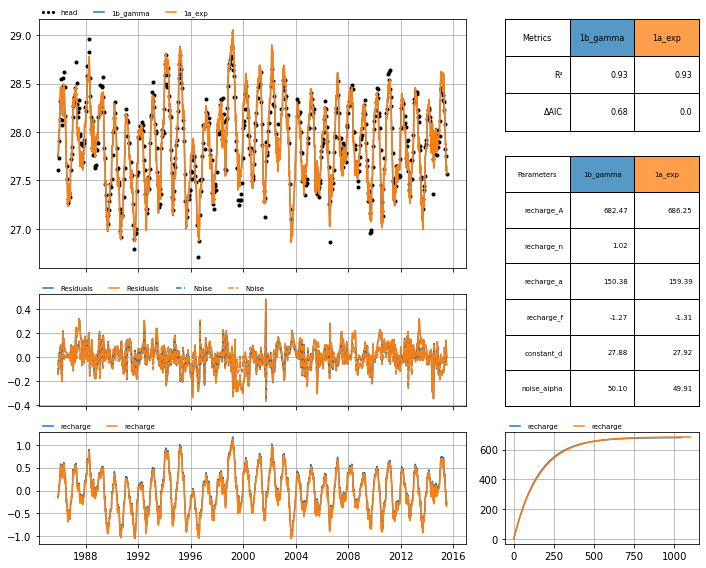

In [5]:
mlcompare = ModelComparison(models=[ml1b, ml1a])
axes = mlcompare.plot()
# mlcompare.get_default_mosaic()
# mlcompare.initialize_figure()


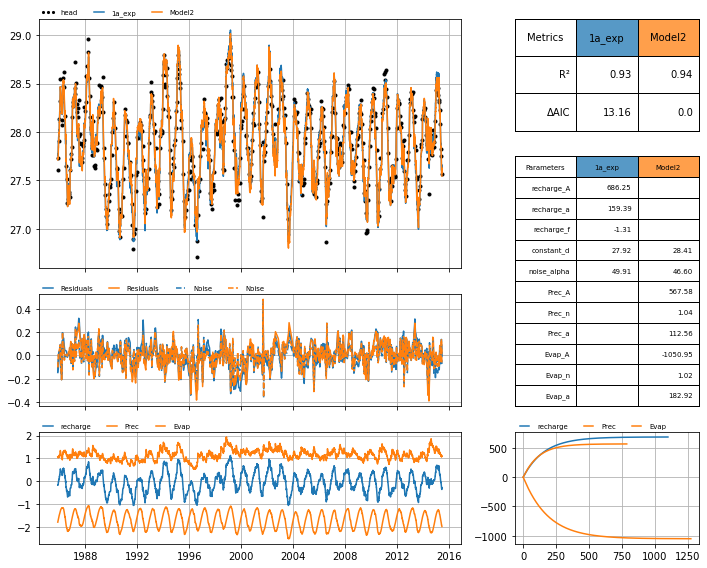

In [6]:
# models with different oseries
mlcompare = ModelComparison(models=[ml1a, ml2])
mosaic = mlcompare.get_default_mosaic(n_stressmodels=1)
mlcompare.initialize_figure(mosaic=mosaic)
axes = mlcompare.plot(smdict={0: ["recharge", "Prec", "Evap"]})


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['rain', 'evap']"}>,
 <AxesSubplot:title={'center':'Step response'}, xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=5)'}>]

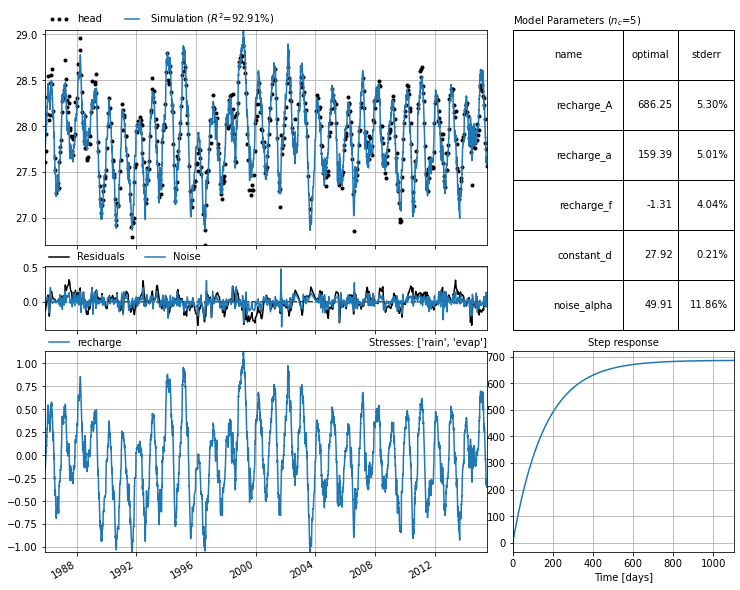

In [7]:
ml1a.plots.results()


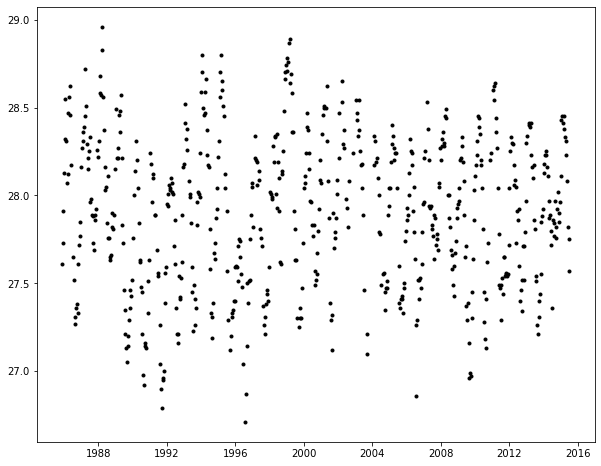

In [8]:
mlcompare = ModelComparison(models=[ml1a, ml1b])
mlcompare.plot_oseries()


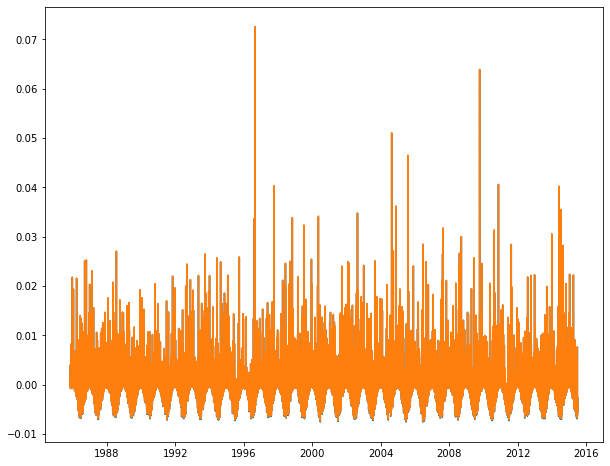

In [9]:
mlcompare = ModelComparison(models=[ml1a, ml1b])
mlcompare.plot_stress()


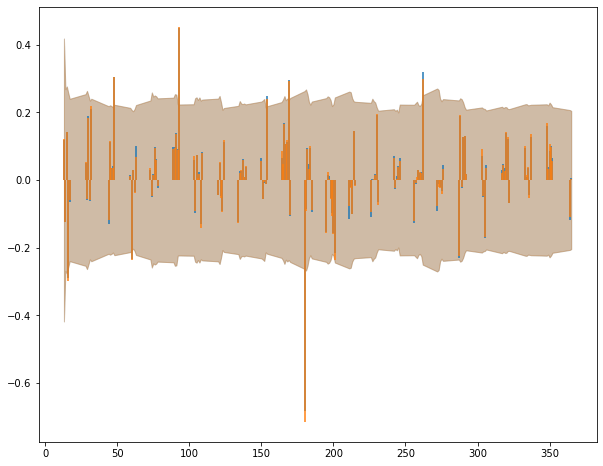

In [10]:
mlcompare = ModelComparison(models=[ml1a, ml1b])
mlcompare.plot_acf()


# Other compare options

In [11]:
# get minimum tmin and maximum tmax
mlcompare.get_tmin_tmax()


,tmin,tmax
1a_exp,1985-11-14,2015-06-28
1b_gamma,1985-11-14,2015-06-28


In [12]:
# get table with all parameters
mlcompare.get_parameters()


,1a_exp,1b_gamma
recharge_A,686.247177,682.470018
recharge_a,159.386055,150.381423
recharge_f,-1.305359,-1.271045
constant_d,27.920134,27.882279
noise_alpha,49.911863,50.095089
recharge_n,NaN,1.018207


In [13]:
# get table with parameters selected by substring
mlcompare.get_parameters(param_selection=['_A'])


,1a_exp,1b_gamma
recharge_A,686.247177,682.470018


In [14]:
# get table with all p-values of statistical tests
mlcompare.get_diagnostics()


,1a_exp_pvalue,1b_gamma_pvalue
Shapiroo,0.00,0.00
D'Agostino,0.00,0.00
Runs test,0.64,0.27
Stoffer-Toloi,0.08,0.08


In [15]:
mlcompare.get_metrics()


,1a_exp,1b_gamma
rmse,0.114420,0.114492
rmsn,0.079585,0.079510
sse,8.431168,8.441825
mae,0.090044,0.090257
nse,0.929135,0.929046
evp,92.913581,92.904645
rsq,0.929135,0.929046
bic,-3235.196225,-3230.051307
aic,-3257.534719,-3256.857500


## Add custom mosaic, normalize contributions and selection of parameters

[None, None, None, None, None, None, None, None]

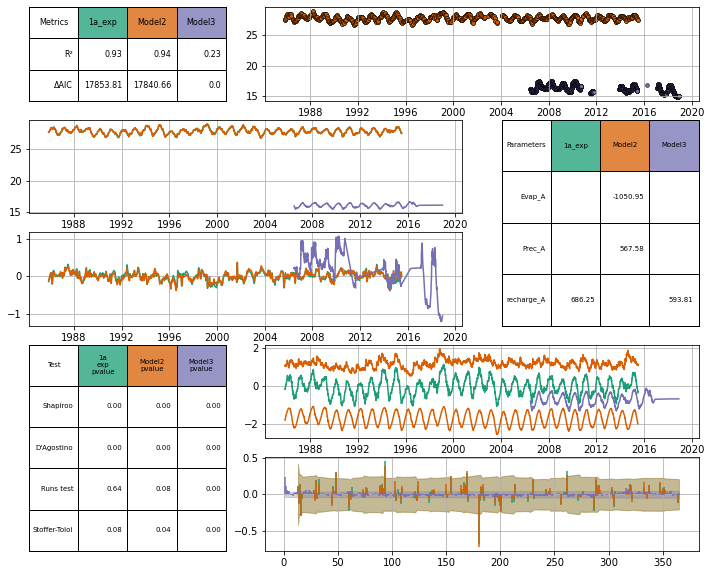

In [16]:
mosaic = [['met', 'ose', 'ose'],
          ['sim', 'sim', 'tab'],
          ['res', 'res', 'tab'],
          ['dia', 'con0', 'con0'],
          ['dia', 'acf', 'acf']]
mlcompare = ModelComparison(models=[ml1a, ml2, ml3])
mlcompare.initialize_figure(mosaic, figsize=(12, 10), cmap="Dark2")
mlcompare.plot_table_metrics()
mlcompare.plot_oseries(axn="ose")
mlcompare.plot_simulation()
mlcompare.plot_table_params(param_selection=["_A"])
mlcompare.plot_residuals()
mlcompare.plot_table_diagnostics(axn="dia")
mlcompare.plot_contribution(
    smdict={0: ["Prec", "Evap", "Rech", "recharge"]}, axn="con{i}")
# mlcompare.plot_stress()
mlcompare.plot_acf(axn="acf")
axes = mlcompare.axes
[axes[x].grid() for x in axes]
